In [1]:
# %matplotlib nbagg
# %matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import os
import time
from datetime import datetime

sys.path.append("..")
# 自分のpath
os.chdir("/home/nakamura/HAI/main_server/hai")

import coloredlogs, logging
logger = logging.getLogger(__name__)
coloredlogs.install(level='CRITICAL', logger=logger)

import pymongo
from pymongo import MongoClient
from PIL import Image
from matplotlib import pylab as plt
from matplotlib.animation import ArtistAnimation
import matplotlib.animation as animation
import numpy as np
import scipy
from bson.objectid import ObjectId
from sklearn.decomposition import PCA

from notebooks.utils.utils import visualize, display_latest_image, display_image, print_time, strtime_to_epoch, epoch_to_strtime
from controllers.learner.img2vec import NNFeatures
import controllers.learner.datasets as ds

mongo = MongoClient('localhost', 20202).hai
from flask import Flask
app = Flask(__name__)
app.config.from_pyfile(filename="application.cfg")

True

In [2]:
def display_latest_image():
    # only display latest image
    images = mongo.images.find({"cam_id": "webcam0"}, sort=[("_id", pymongo.DESCENDING)])
    im = images.next()
    display_image(im)

def display_image(im):
    print_time(im['time'])  
    plt.imshow(Image.open(app.config['RAW_IMG_DIR'] + im['filename']))
    
def print_time(t):
    print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t)))
%matplotlib nbagg

class UpdateDist(object):
    def __init__(self, axL, axR, image_pairs):
        self.image_pairs = image_pairs
        self.axL = axL
        self.axR = axR
        
        self.axL.set_xticklabels([]) 
        self.axR.set_xticklabels([]) 
        self.axL.set_yticklabels([]) 
        self.axR.set_yticklabels([]) 
        self.axL.grid(False)
        self.axR.grid(False)
        
    def __call__(self, i):
        self.axR.clear()
        im0 = self.image_pairs[i][0]
        im0_path = app.config['RAW_IMG_DIR'] + im0['filename']
        img0 = Image.open(im0_path, 'r')
        self.axR.imshow(img0)
        self.axR.text(0, 1.0, epoch_to_strtime(im0['time']),
                 horizontalalignment='left',verticalalignment='bottom')
    
        self.axL.clear()
        im1 = self.image_pairs[i][1]
        im1_path = app.config['RAW_IMG_DIR'] + im1['filename']
        img1 = Image.open(im1_path, 'r')
        self.axL.imshow(img1)
        self.axL.text(0, 1.0, epoch_to_strtime(im1['time']),
                 horizontalalignment='left',verticalalignment='bottom')
        
        return self.axL, self.axR
        
# def view_all_images(image_pairs):
#     num = len(image_pairs)
#     fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))


#     def update_plot(image_pair):
#         axR.clear()
#         im0 = image_pair[0]
#         im0_path = app.config['RAW_IMG_DIR'] + im0['filename']
#         img0 = Image.open(im0_path, 'r')
#         axR.imshow(img0)
#         axR.text(0, 1.0, epoch_to_strtime(im0['time']),
#                  horizontalalignment='left',verticalalignment='bottom', transform=axR.transAxes)
    
#         axL.clear()
#         im1 = image_pair[1]
#         im1_path = app.config['RAW_IMG_DIR'] + im1['filename']
#         img1 = Image.open(im1_path, 'r')
#         axL.imshow(img1)
#         axL.text(0, 1.0, epoch_to_strtime(im1['time']),
#                  horizontalalignment='left',verticalalignment='bottom', transform=axL.transAxes)
        
#         return axL, axR


#     ani = animation.FuncAnimation(fig, update_plot, frames=image_pairs, interval=1000)
#     # ani.save('data1103.mp4', writer="ffmpeg")
#     return fig

In [82]:
# Todo: start time end time
munual_changes = mongo.hue.find({'state_changed': 'True', 'program_control': 'False'}, sort=[("_id", pymongo.DESCENDING)])

In [87]:
from bson.son import SON
pipeline = [
    {"$group": {"_id": "$lights", "count": {"$sum": 1}}},
    {"$sort": SON([("count", -1), ("_id", -1)])}
]

In [94]:
hoge = mongo.hue.aggregate(pipeline)

In [100]:
hoge.next()

{'_id': '[{"swupdate": {"lastinstall": null, "state": "readytoinstall"}, "name": "Hue color lamp 1", "uniqueid": "00:17:88:01:02:e0:35:a6-0b", "id": "1", "state": {"reachable": true, "sat": 0, "hue": 2049, "alert": "none", "xy": [0.3804, 0.3768], "colormode": "ct", "on": true, "effect": "none", "ct": 250, "bri": 254}, "swversion": "5.38.1.14919", "type": "Extended color light", "manufacturername": "Philips", "modelid": "LCT007"}, {"swupdate": {"lastinstall": null, "state": "readytoinstall"}, "name": "Hue color lamp 2", "uniqueid": "00:17:88:01:02:44:79:36-0b", "id": "2", "state": {"reachable": true, "sat": 0, "hue": 2049, "alert": "none", "xy": [0.3804, 0.3768], "colormode": "ct", "on": true, "effect": "none", "ct": 250, "bri": 254}, "swversion": "5.38.1.14919", "type": "Extended color light", "manufacturername": "Philips", "modelid": "LCT007"}, {"swupdate": {"lastinstall": null, "state": "readytoinstall"}, "name": "Hue color lamp 3", "uniqueid": "00:17:88:01:02:44:7b:b6-0b", "id": "3"

In [77]:
start_time = munual_changes.next()['time']
next_change_time = time.time()
size = 20 * 60 # 20m

if next_change_time > start_time + size:
    end_time = start_time + size
else:
    end_time = next_change_time

ims_cam0 = mongo.images.find({'cam_id': 'webcam0', 'time': {"$gte": start_time, "$lt": end_time}})
ims_cam1 = mongo.images.find({'cam_id': 'webcam1', 'time': {"$gte": start_time, "$lt": end_time}})

In [78]:
def safe_next(imgs):
    while True:
        img = imgs.next()
        try:
            scipy.misc.imread(app.config['RAW_IMG_DIR'] +  img["filename"])
            break
        except:
            continue
    return img

In [79]:
def pair_images(ims_cam0, ims_cam1):
    # Images should be sorted in ascending order.
    im_pairs = []
    try:
        target = safe_next(ims_cam0)
        earlier_img = safe_next(ims_cam1)
        while target['time'] < earlier_img['time']:
            target = safe_next(ims_cam0)
        latter_img = safe_next(ims_cam1)

        while True:
            while target['time'] > latter_img['time']:
                earlier_img = latter_img
                latter_img = safe_next(ims_cam1)
            if latter_img['time'] - target['time'] > target['time'] - earlier_img['time']:
                im_pairs.append((target, earlier_img))
            else:
                im_pairs.append((target, latter_img))
            target = safe_next(ims_cam0)

    except StopIteration:
        return im_pairs


In [80]:
res = pair_images(ims_cam0, ims_cam1)

<IPython.core.display.Javascript object>


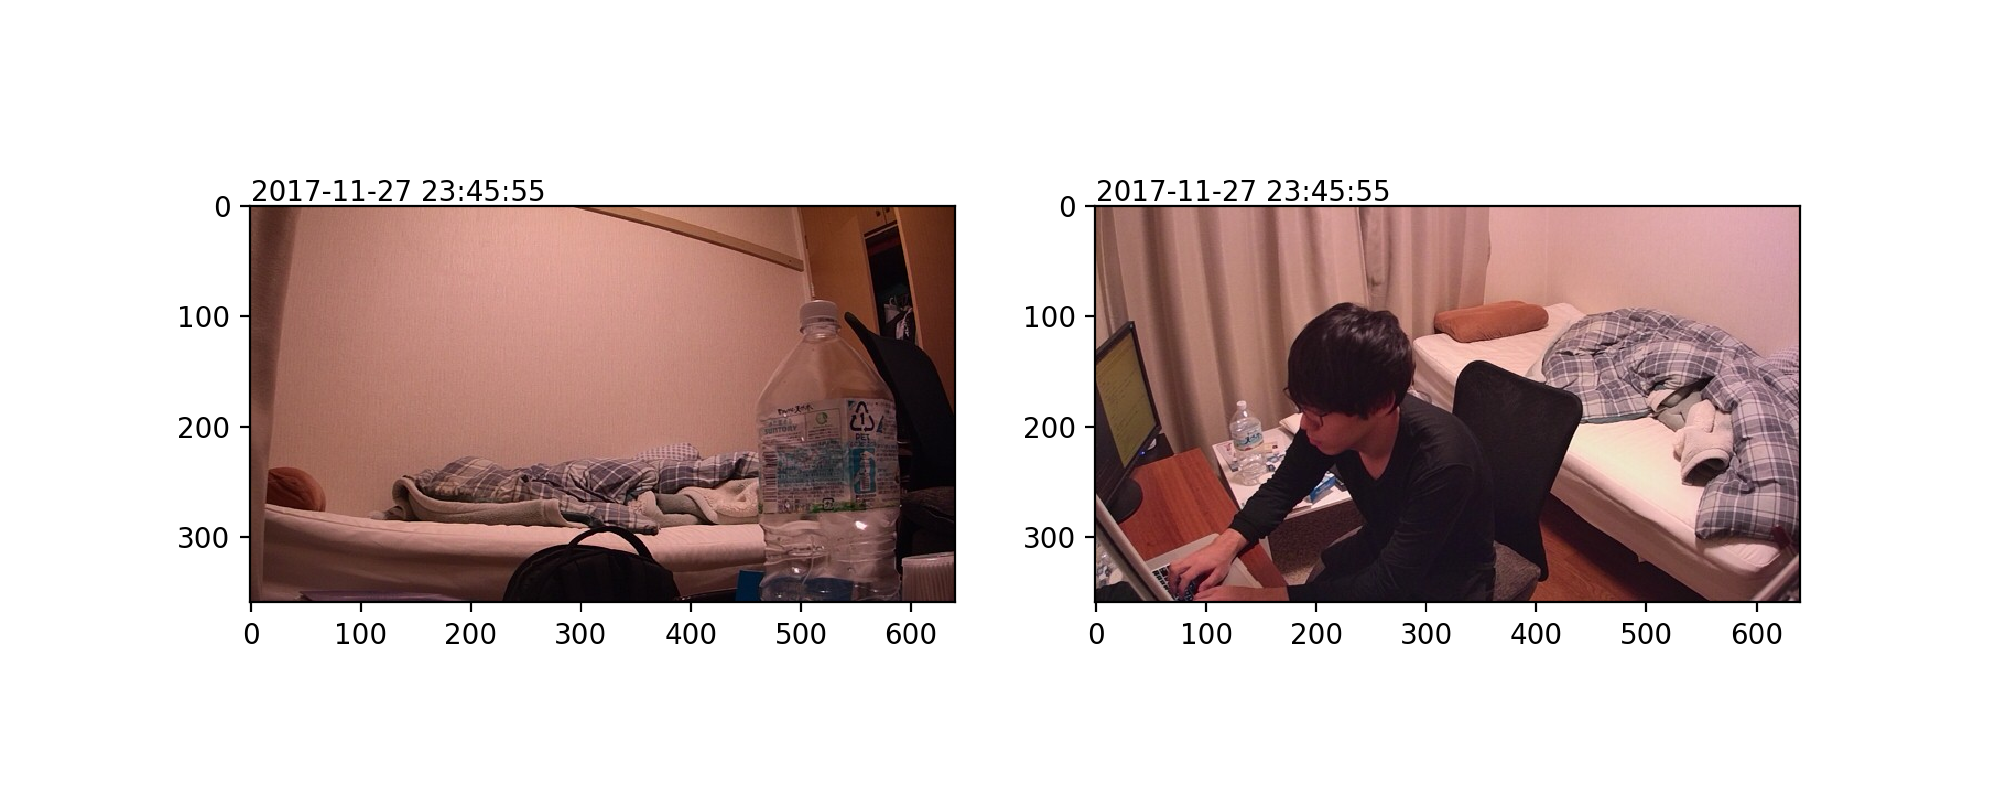

In [81]:
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
ud = UpdateDist(axL, axR, res)
ani = animation.FuncAnimation(fig, ud, frames=range(len(res)), interval=2000)
fig.show()

In [95]:
%matplotlib nbagg
# view_all_images(res)

In [94]:
target0['time'] < target1['time']

False

In [95]:
target0['time'] < next_target1['time']

True

In [3]:
nn = NNFeatures()
from controllers.learner.datasets import get_dataset
username = 'koki'
start_time = 1509739849#1509725879#1509715875
end_time = time.time()
get_dataset(username, start_time, end_time, nn)

ImportError: cannot import name 'get_dataset'

In [10]:
start = '2017-11-01 16:00:07'
end = '2017-11-01 18:16:56'
st = strtime_to_epoch(start)
et = strtime_to_epoch(end)
# st = prints[0]['time'] - 0.1
# et = prints[-1]['time'] + 0.1

images0 = mongo.images.find({'time': {"$gt": st, "$lt": et}, "cam_id": "webcam0"}, sort=[("_id", pymongo.ASCENDING)])
images1 = mongo.images.find({'time': {"$gt": st, "$lt": et}, "cam_id": "webcam1"}, sort=[("_id", pymongo.ASCENDING)])

In [11]:
data = pair_images(images0)

In [25]:
# 0: 勉強 →　１
# 1: くつろぎ　→　0 
# 2: 就寝 →　2
def get_huelabel(t):
    if t < strtime_to_epoch('2017-11-01 16:05:44'):
        return 1
    elif t < strtime_to_epoch('2017-11-01 16:06:44'):
        return 0
    elif t < strtime_to_epoch('2017-11-01 16:52:29'):
        return 2
    elif t < strtime_to_epoch('2017-11-01 16:57:15'):
        return 0
    elif t < strtime_to_epoch('2017-11-01 17:19:15'):
        return 2
    elif t < strtime_to_epoch('2017-11-01 17:38:38'):
        return 0
    elif t < strtime_to_epoch('2017-11-01 18:10:44'):
        return 1
    elif t < strtime_to_epoch('2017-11-01 18:14:12'):
        return 0
    else:
        return 2

In [28]:
labels = []
for im0, im1 in data:
    labels.append(get_huelabel(im0['time']))
print(len(data), len(labels))

1866 1866


In [17]:
nn = NNFeatures()
X = list()
for d0, d1 in data[:300]:
    input_image = list()
    input_image.append(Image.open(app.config['RAW_IMG_DIR'] + d0['filename']))
    input_image.append(Image.open(app.config['RAW_IMG_DIR'] + d1['filename']))
    features = nn.img2vec(input_image)
    X.append(np.concatenate((features[0], features[1])))

Y = labels

0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2
0/2
1/2


In [29]:
Y = labels

In [30]:
from sklearn.externals import joblib
clf = joblib.load('clf1103.pkl') 
clf.score(X, Y[:300])

0.45000000000000001

In [31]:
clf.predict(X)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [36]:
np.array(Y[:300])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2])